In [2]:
import pandas  as pd
import xgboost as xgb
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import os
from utils import run_kfold_eval, calculate_metric
import optuna
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import shap
import numpy as np

Python(12799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [3]:
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../output/xgboost'
TRAINING_OUTPUT_FILE = '../output/train_predictions.xlsx'
TEST_OUTPUT_FILE = '../output/test_predictions.xlsx'
SHEET_NAME = "xgboost"
OUTPUT_FILE =  OUTPUT_PATH + '/model.pkl'

In [4]:
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [5]:
test_features.head()

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,3.125,-122.39680,-0.001341,1.116103,396.408936,399.031738,455.0625,383.612488,341.675812,0.1734,...,False,False,False,False,False,False,False,False,False,False
1,15.000,156.01912,0.000790,6.372588,107.083778,76.414360,118.2482,113.403519,147.756165,0.0253,...,False,False,False,False,False,False,False,False,False,False
2,0.000,-451.10824,-0.002033,43.914617,637.607544,689.770996,683.3611,589.969666,529.166992,0.0406,...,False,False,False,True,False,False,False,False,False,False
3,5.875,-751.22120,-0.000435,74.783398,153.653778,129.425842,158.3252,172.708054,187.147980,1.4908,...,False,False,False,False,False,False,False,False,False,False
4,10.000,55.69036,0.000712,-28.522133,152.290619,148.385330,222.1811,142.140915,159.624313,0.0763,...,False,False,False,False,False,False,False,False,False,False


In [6]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(1293, 317)
(1293, 1)
(432, 317)
(432, 1)


In [7]:
feature_list = train_features.columns
# category_feature_key = ['currency', 'seniorioty_adj', 'domicile_country',	'exchange_country',	'Industry_sector',	'Industry_group',	'Industry_subgroup', 'event_type',
#                  'event_type_subcategory_sum', 'defaulted_in_last_6_months']
# category_features = [i for i in feature_list if any(sub in i for sub in category_feature_key)]
category_features = train_features.select_dtypes(include=['int', 'bool']).columns
non_category_features = [i for i in feature_list if i not in category_features]

print(len(category_features))
print(len(non_category_features))

164
153


In [8]:
category_features

Index(['defaulted_in_last_5_years', 'defaulted_in_last_6_months',
       'currency_CAD', 'currency_CHF', 'currency_CNY', 'currency_EUR',
       'currency_GBP', 'currency_HKD', 'currency_INR', 'currency_ISK',
       ...
       'event_type_subcategory_sum_Missing Coupon payment only',
       'event_type_subcategory_sum_Missing Interest payment',
       'event_type_subcategory_sum_Missing Loan payment',
       'event_type_subcategory_sum_Missing Principal payment',
       'event_type_subcategory_sum_Others',
       'event_type_subcategory_sum_Pre-Negotiated Chapter 11',
       'event_type_subcategory_sum_Protection',
       'event_type_subcategory_sum_Receivership',
       'event_type_subcategory_sum_Rehabilitation',
       'event_type_subcategory_sum_Restructuring'],
      dtype='object', length=164)

In [9]:
# Normalize the data
# Prepare the ColumnTransformer

scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), non_category_features)   # StandardScaler()
    ],
    remainder='passthrough'  # Leave categorical features untouched
)

In [34]:
def objective(trial):

    param = {
        # "verbosity": 0,
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        # "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        # "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }
    
    if param["booster"] in "gbtree":
        # sampling according to each tree.
        param["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.2, 1.0)
        # sampling ratio for training data.
        param["subsample"] = trial.suggest_float("subsample", 0.2, 1.0)
        # use exact for small dataset.
        param["tree_method"] = trial.suggest_categorical("tree_method", ["exact", "auto"])

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 28, step=2)
        # minimum child weight, larger the term more conservative the tree.
        # param["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        # param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        # param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    model = xgb.XGBRegressor(n_jobs=-1, **param)
    
    pipeline = Pipeline([
        ('preprocessor', scaler),
        ('xgboost', model)
    ])
    
    score = cross_val_score(pipeline, train_features, train_labels.to_numpy(), cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [35]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-03-31 10:43:32,045] A new study created in memory with name: no-name-7added1c-4cad-4c2a-b8b5-c446a88f7eb4


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-03-31 10:43:41,735] Trial 0 finished with value: -0.10611310102842102 and parameters: {'n_estimators': 256, 'booster': 'gblinear'}. Best is trial 0 with value: -0.10611310102842102.
[I 2025-03-31 10:45:50,202] Trial 1 finished with value: -0.09102726929394174 and parameters: {'n_estimators': 112, 'booster': 'dart', 'max_depth': 20, 'eta': 0.006155859424843483, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11973597079741219, 'skip_drop': 6.267734608720116e-05}. Best is trial 1 with value: -0.09102726929394174.
[I 2025-03-31 10:50:12,631] Trial 2 finished with value: -0.060949678021491684 and parameters: {'n_estimators': 275, 'booster': 'dart', 'max_depth': 10, 'eta': 0.013981320494740003, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.1067633467471268e-05, 'skip_drop': 0.07312135593664439}. Best is trial 2 with value: -0.060949678021491684.
[I 2025-03-31 10:50:15,315] Trial 3 finished with value: -0.10766915302854844 and parameters: {'

In [36]:
study.best_params

{'n_estimators': 353,
 'booster': 'dart',
 'max_depth': 6,
 'eta': 0.046653323948485266,
 'sample_type': 'uniform',
 'normalize_type': 'forest',
 'rate_drop': 4.201145869116434e-06,
 'skip_drop': 0.0013199458257448385}

In [10]:
best_params = {'n_estimators': 353,
 'booster': 'dart',
 'max_depth': 6,
 'eta': 0.046653323948485266,
 'sample_type': 'uniform',
 'normalize_type': 'forest',
 'rate_drop': 4.201145869116434e-06,
 'skip_drop': 0.0013199458257448385}

In [11]:
start_time = time.time()

# Get the best hyperparameters
# best_params = study.best_params

# Train the final model on the entire training data
model = xgb.XGBRegressor(n_jobs=-1, **best_params)
pipeline = Pipeline([
    ('preprocessor', scaler),
    ('xgboost', model)
])
pipeline.fit(train_features, train_labels.to_numpy())

elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

Training time: 161.766 seconds


In [12]:
# do prediction
train_predictions = pipeline.predict(train_features)
# save metrics
mae, mape, rmse, rsqr = calculate_metric(train_predictions, train_labels.to_numpy())
print(f"Train average mean absolute error: {mae}")
print(f"Train average mean absolute percentage error: {mape}")
print(f"Train average root mean squared error: {rmse}")
print(f"Train average R2: {rsqr}")

Train average mean absolute error: 0.36167034396844366
Train average mean absolute percentage error: 4656.71870031292
Train average root mean squared error: 0.06545620501087729
Train average R2: 0.9605067884270344


In [13]:
# do prediction
predictions = pipeline.predict(test_features)
# save metrics
mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels.to_numpy())
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")

Val average mean absolute error: 0.35368142417947634
Val average mean absolute percentage error: 393.06060456616655
Val average root mean squared error: 0.2140720239411041
Val average R2: 0.5999193821903368


In [17]:
# save train predictions
train_predictions_df = pd.DataFrame({"predictions": train_predictions})
with pd.ExcelWriter(TRAINING_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    train_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)
    
# save test predictions
test_predictions_df = pd.DataFrame({"predictions": predictions})
with pd.ExcelWriter(TEST_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    test_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)

# Save the best model
joblib.dump(pipeline, OUTPUT_FILE)

['../output/xgboost/xgboost.pkl']

In [17]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': feature_list,
    'Importance': model.feature_importances_
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

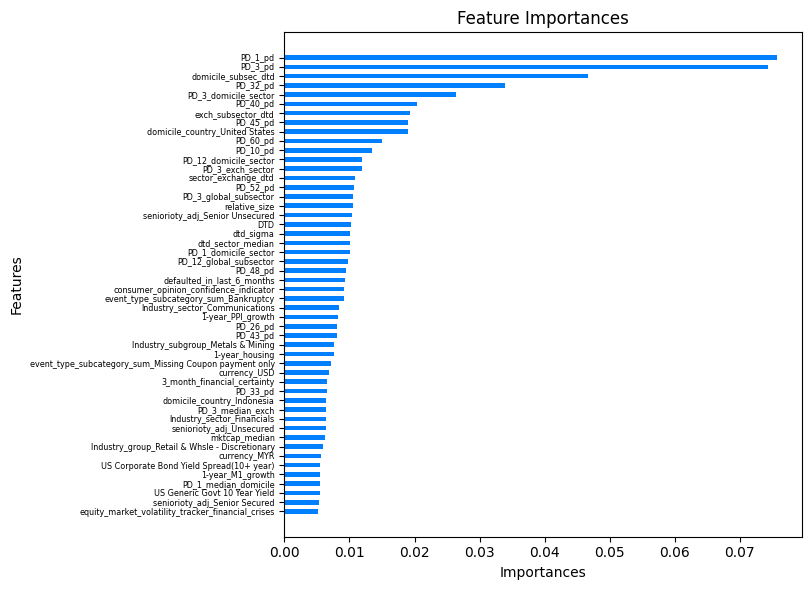

In [81]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'].tail(50), feature_importances['Importance'].tail(50), color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')
plt.savefig(os.path.join(OUTPUT_PATH,'rf_feature_importance.png'))

plt.show()

SHAP

In [15]:
new_feature_list = non_category_features + category_features.to_list()

SHAP on training set

In [16]:
# standardize train features first
train_ft_scaled = pipeline.named_steps['preprocessor'].transform(train_features)
train_ft_scaled_df = pd.DataFrame(data=train_ft_scaled, columns=new_feature_list)

explainer = shap.TreeExplainer(model)
explanation = explainer(train_ft_scaled_df)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - train_predictions).max()

1.1920929e-06

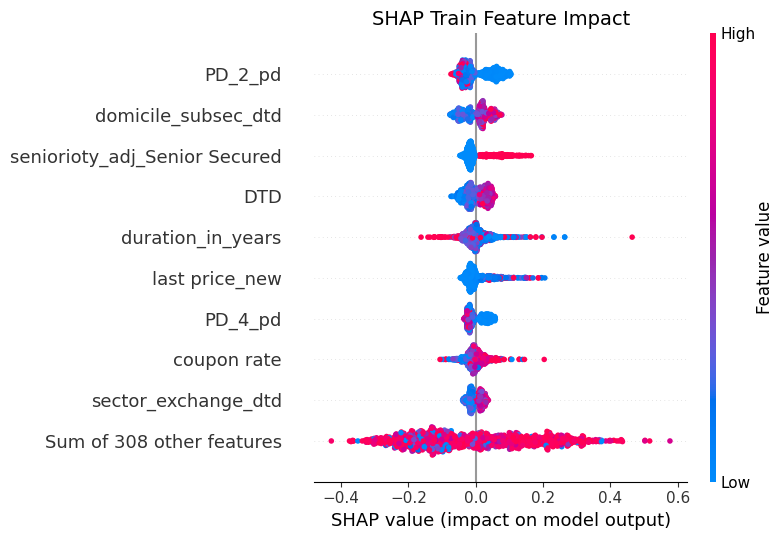

In [17]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))  # Adjust size as needed
# Create the beeswarm plot
shap.plots.beeswarm(explanation, show=False)  # Set show=False to prevent automatic display
# Add title if desired
plt.title("SHAP Train Feature Impact", fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_train_feature_beeswarm.png')
plt.show()

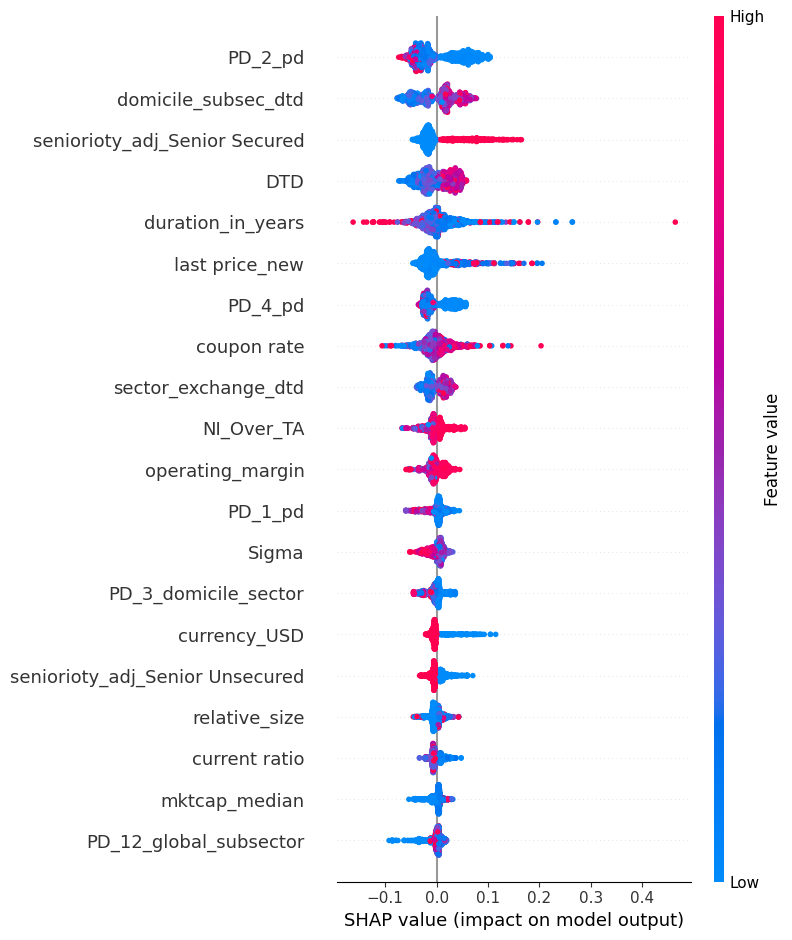

In [18]:
shap.summary_plot(shap_values, train_ft_scaled_df)

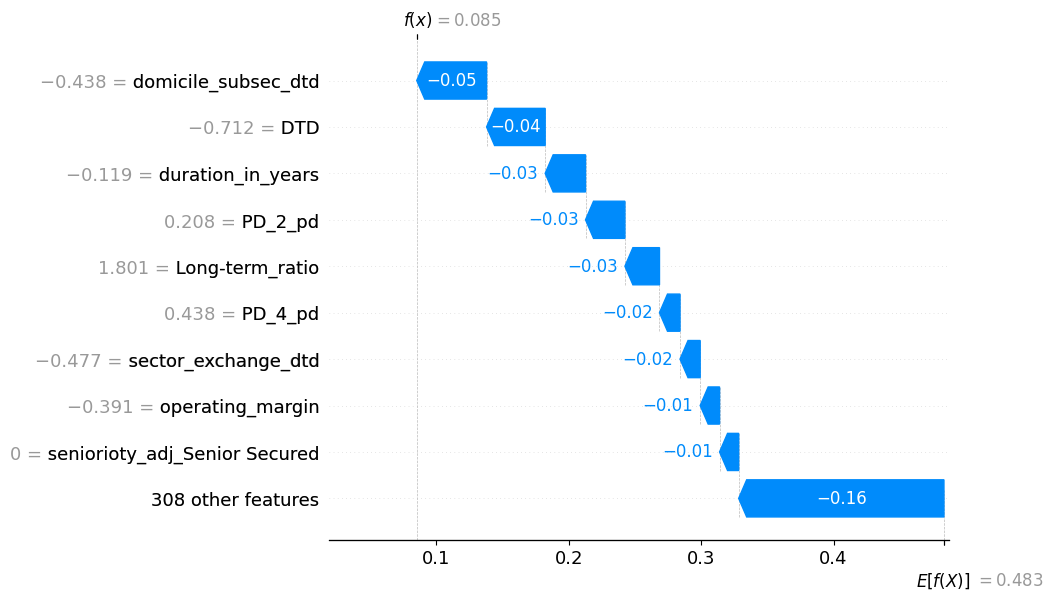

In [20]:
shap.plots.waterfall(explanation[0])

SHAP on testing set

In [21]:
# standardize test features first
test_ft_scaled = pipeline.named_steps['preprocessor'].transform(test_features)
test_ft_scaled_df = pd.DataFrame(data=test_ft_scaled, columns=new_feature_list)

explainer = shap.TreeExplainer(model)
explanation = explainer(test_ft_scaled_df)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - predictions).max()

1.2516975e-06

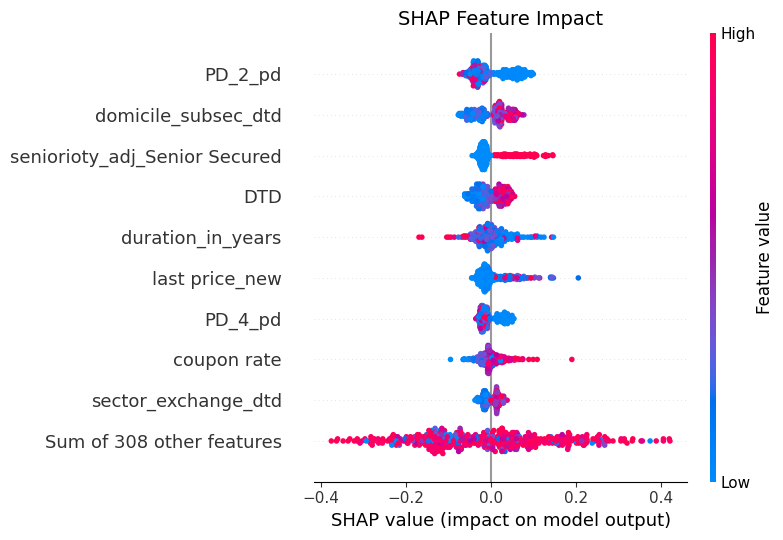

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))  # Adjust size as needed
# Create the beeswarm plot
shap.plots.beeswarm(explanation, show=False)  # Set show=False to prevent automatic display
# Add title if desired
plt.title("SHAP Feature Impact", fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_feature_beeswarm.png')
plt.show()

In [26]:
shap_interaction_values = explainer.shap_interaction_values(test_ft_scaled_df)
print(f"shape: ", shap_interaction_values.shape)

shape:  (432, 317, 317)


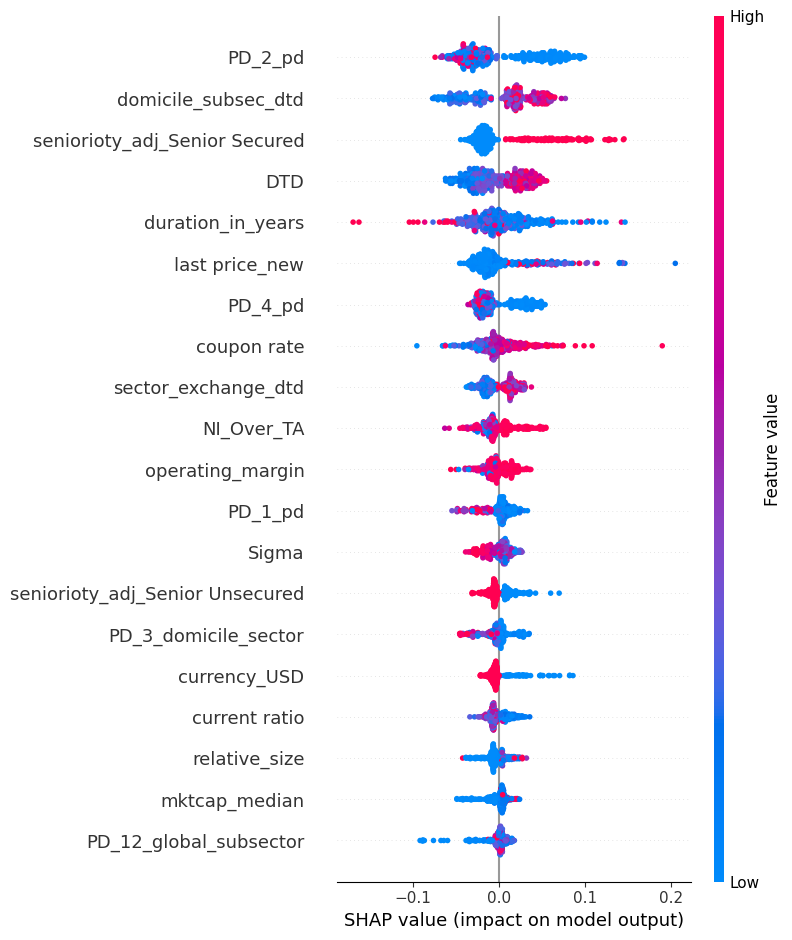

In [23]:
shap.summary_plot(shap_values, test_ft_scaled_df)

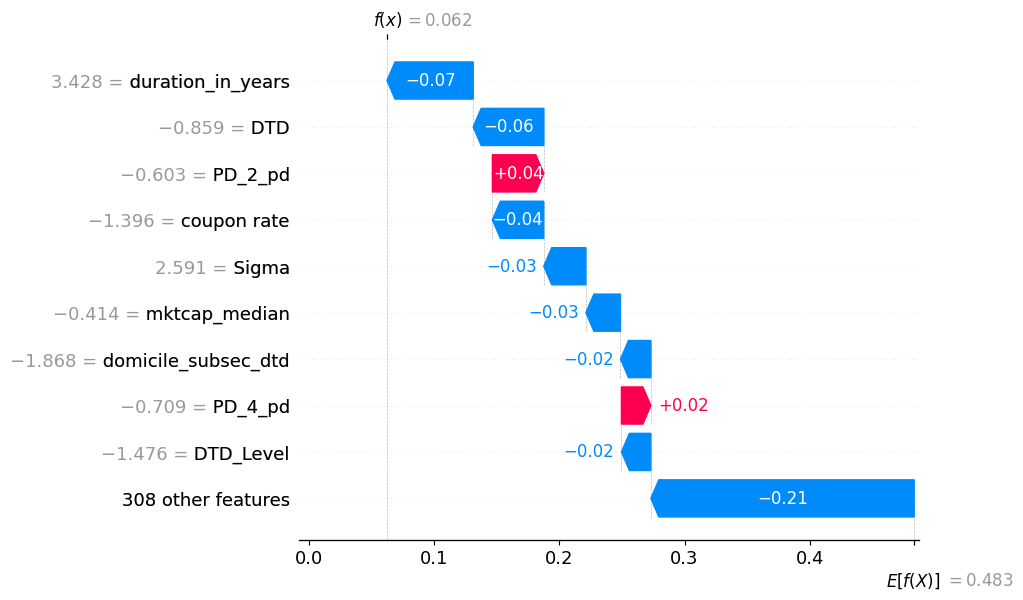

In [24]:
shap.plots.waterfall(explanation[0])

In [ ]:

# Aggregate interaction effects across samples
interaction_matrix = np.abs(shap_interaction_values).sum(0)

# Create a DataFrame for easy manipulation
interaction_df = pd.DataFrame(
    interaction_matrix,
    index=test_ft_scaled_df.columns,
    columns=test_ft_scaled_df.columns
)

# Display top interactions
print("\nTop 10 feature interactions (summed absolute SHAP interaction values):")
# Create a list of all interactions
interactions = []
for i in range(len(test_ft_scaled_df.columns)):
    for j in range(i+1, len(test_ft_scaled_df.columns)):  # j > i to avoid duplicates
        feature1 = test_ft_scaled_df.columns[i]
        feature2 = test_ft_scaled_df.columns[j]
        interaction_strength = interaction_df.iloc[i, j] + interaction_df.iloc[j, i]
        interactions.append((feature1, feature2, interaction_strength))

# Sort by interaction strength and display top 10
interactions.sort(key=lambda x: x[2], reverse=True)
top_interactions = interactions[:10]

for feature1, feature2, strength in top_interactions:
    print(f"{feature1} × {feature2}: {strength:.6f}")

# Calculate total interaction strength for each feature
feature_interaction_strength = np.zeros(len(test_ft_scaled_df.columns))
for i in range(len(test_ft_scaled_df.columns)):
    for j in range(len(test_ft_scaled_df.columns)):
        if i != j:  # Exclude self-interactions (main effects)
            feature_interaction_strength[i] += interaction_df.iloc[i, j]

# Create a DataFrame for visualization
interaction_strength_df = pd.DataFrame({
    'Feature': test_ft_scaled_df.columns,
    'Interaction Strength': feature_interaction_strength
}).sort_values('Interaction Strength', ascending=False)

print("\nFeatures ranked by total interaction strength:")
print(interaction_strength_df)


Top 10 feature interactions (summed absolute SHAP interaction values):
domicile_subsec_dtd × PD_2_pd: 7.165994
PD_3_domicile_sector × PD_2_pd: 3.868265
DTD × NI_Over_TA: 3.423346
PD_12_global_subsector × seniorioty_adj_Senior Secured: 3.102806
PD_1_domicile_sector × PD_4_pd: 3.025572
relative_size × PD_2_pd: 2.886918
last price_new × PD_2_pd: 2.852316
domicile_subsec_dtd × last price_new: 2.765181
mktcap_median × PD_2_pd: 2.747709
PD_2_pd × seniorioty_adj_Senior Unsecured: 2.494329

Features ranked by total interaction strength:
                                      Feature  Interaction Strength
91                                    PD_2_pd             28.611998
66                          duration_in_years             25.690136
150                                       DTD             21.976147
39                        domicile_subsec_dtd             20.508231
88                             last price_new             19.797275
..                                        ...           

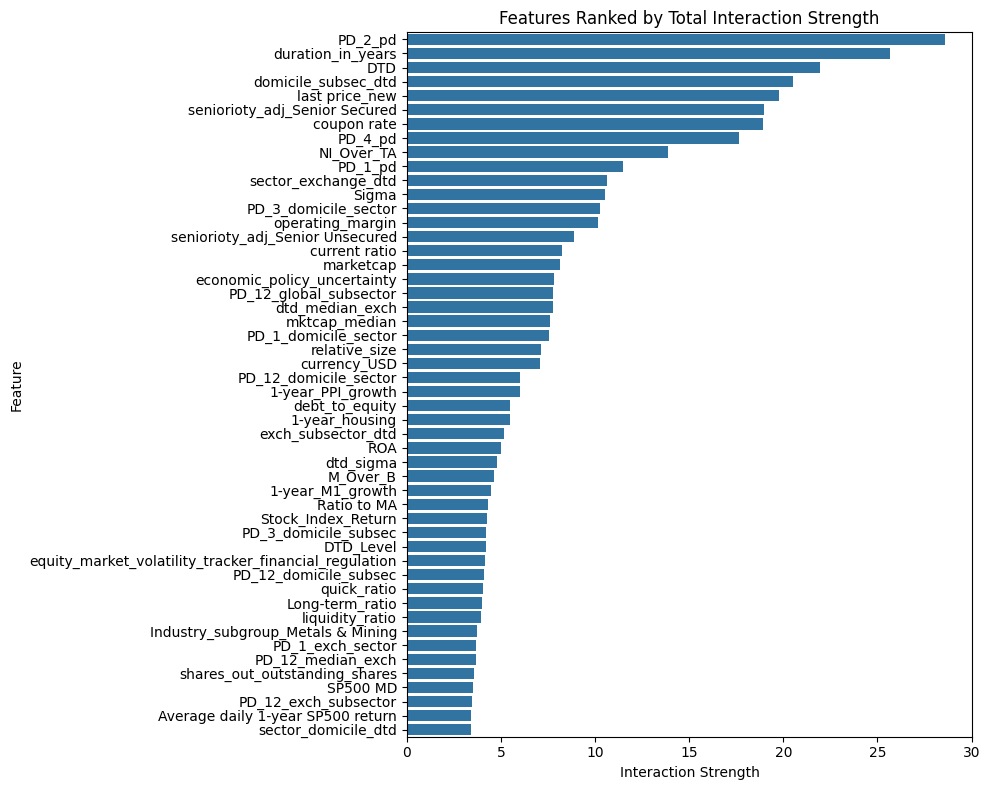

In [41]:
# Visualize feature interaction strengths
plt.figure(figsize=(10, 8))
sns.barplot(x='Interaction Strength', y='Feature', data=interaction_strength_df.iloc[0:50,:])
plt.title('Features Ranked by Total Interaction Strength')
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_feature_interaction_strength.png')
plt.show()

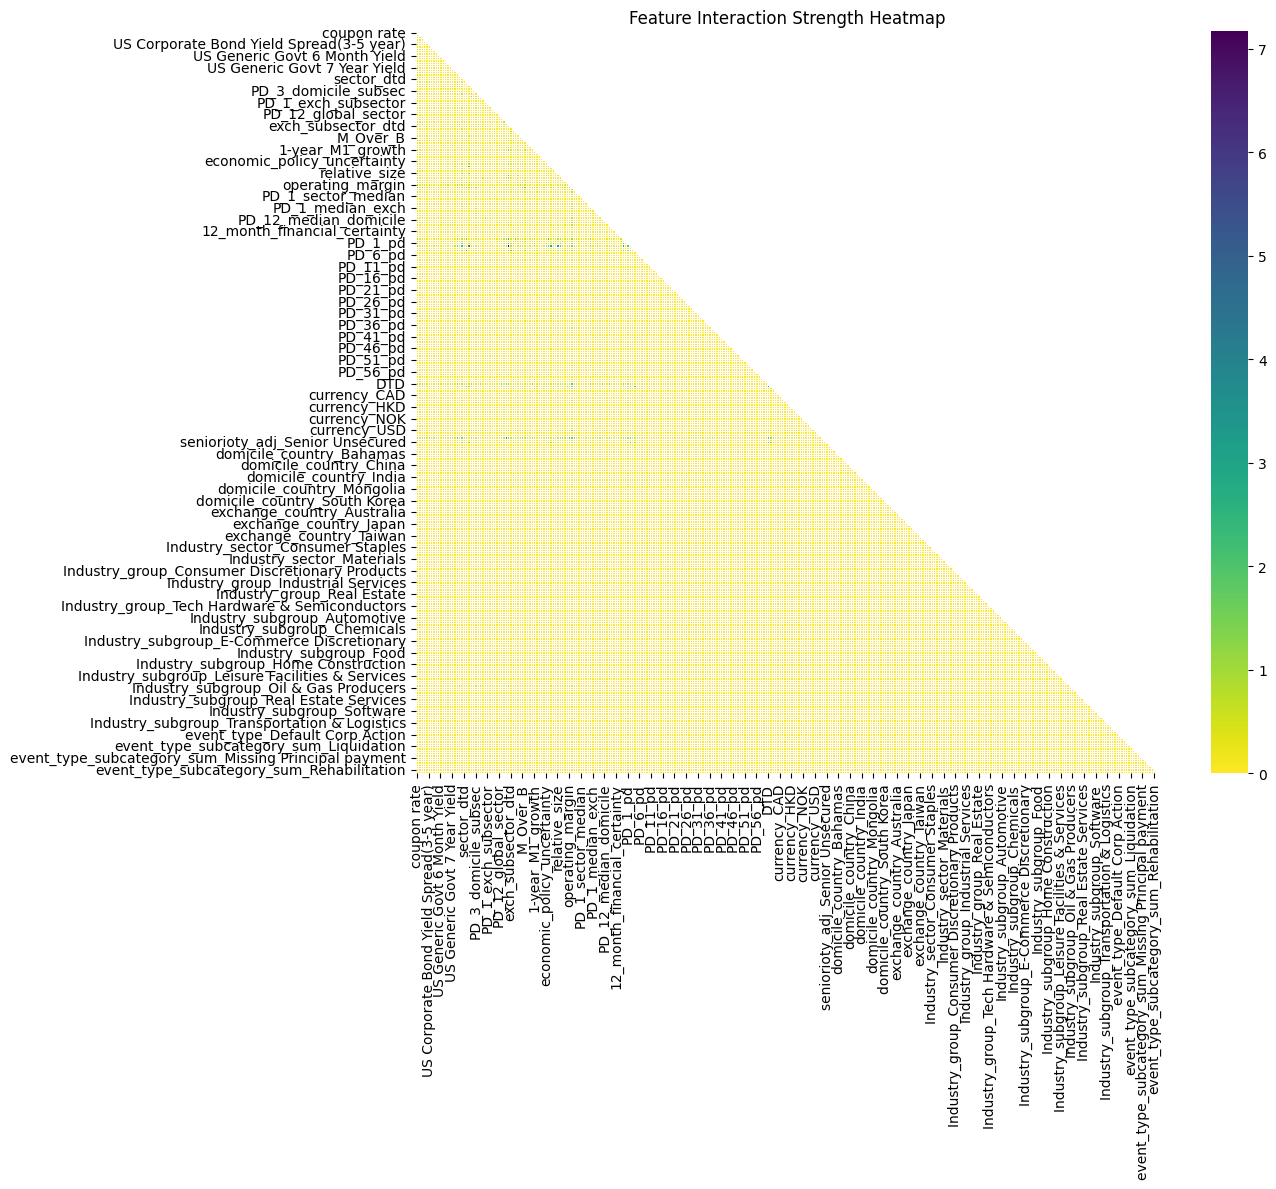

In [40]:
# Create a symmetric interaction matrix for the heatmap
symmetric_interaction = interaction_df.copy()
for i in range(len(test_ft_scaled_df.columns)):
    for j in range(i+1, len(test_ft_scaled_df.columns)):
        # Sum both directions of the interaction
        total = symmetric_interaction.iloc[i, j] + symmetric_interaction.iloc[j, i]
        symmetric_interaction.iloc[i, j] = total
        symmetric_interaction.iloc[j, i] = total
    # Set diagonal to 0 to focus on interactions
    symmetric_interaction.iloc[i, i] = 0

# Plot the heatmap
plt.figure(figsize=(15, 12))
mask = np.zeros_like(symmetric_interaction, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # Mask upper triangle
heatmap = sns.heatmap(
    symmetric_interaction,
    mask=mask,
    cmap='viridis_r',
    linewidths=0.5,
    annot=False,
    square=True
)
plt.title('Feature Interaction Strength Heatmap')
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_interaction_heatmap.png')
plt.show()

5-fold CV

In [47]:
best_params

{'n_estimators': 353,
 'booster': 'dart',
 'max_depth': 6,
 'eta': 0.046653323948485266,
 'sample_type': 'uniform',
 'normalize_type': 'forest',
 'rate_drop': 4.201145869116434e-06,
 'skip_drop': 0.0013199458257448385}

In [48]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,False,False,False,False,False,False,False,False,False,False
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,False,True,False,False,False,False,False,False,False,False
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,False,False,False,False,False,False,False,False,False,False
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,False,False,False,False,False,False,False,False,False,False


In [49]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [50]:
model = xgb.XGBRegressor(n_jobs=-1, **best_params)
pipeline = Pipeline([
    ('preprocessor', scaler),
    ('xgboost', model)
])
# pipeline.fit(train_features, train_labels)

In [51]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(features, labels.to_numpy(), n_folds=5, model=pipeline, model_params=None, output_path=OUTPUT_PATH, name="xgboost")

100%|██████████| 5/5 [09:47<00:00, 117.43s/it]


In [52]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in train_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Training average mean absolute error: {mae/i}")
print(f"Training average mean absolute percentage error: {mape/i}")
print(f"Training average root mean squared error: {rmse/i}")
print(f"Training average R2: {rsqr/i}")

Training average mean absolute error: 0.36248491478093636
Training average mean absolute percentage error: 3596.6230161595768
Training average root mean squared error: 0.0721815089044115
Training average R2: 0.9525188903724278


In [53]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3477921343436612
Test average mean absolute percentage error: 3696.754271353143
Test average root mean squared error: 0.21372332906308555
Test average R2: 0.5830761295545626
